In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms

from cnn_classifier import FashionCNN
import helper as helper
import dataset_helper as dhelper
from dataset_helper import BinaryFashionDataset


In [2]:
# set the device for pytorch
device = helper.set_torch_device()

Setting the device to cuda:0...



# Base CNN and poisoned data trained CNN

These are the class label mappings:
```py
{
	0 = "T-shirt/Top",
	1 = "Trouser", 
	2 = "Pullover", 
	3 = "Dress", 
	4 = "Coat", 
	5 = "Sandal", 
	6 = "Shirt", 
	7 = "Sneaker", 
	8 = "Bag", 
	9 = "Ankle Boot"
}
```

In [3]:
# load data subset from selected classes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

trainset = datasets.FashionMNIST('../MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('../MNIST_data/', download = True, train = False, transform = transform)

In [4]:
classes = {
	0 : "Apparel",
	1: "Accessories"
}

classes_merged_ids = {
	0 : [0,1,2,3,4,6],
	1: [5,7,8,9]
}

In [5]:
train_idx, train_subset, test_subset = dhelper.get_merged_classes(trainset, testset, classes_merged_ids)
trainloader, validloader = dhelper.get_data_loaders(train_subset, 0.2, device)

# common testloader
testloader = torch.utils.data.DataLoader(test_subset, batch_size = 64, shuffle = True, generator=torch.Generator(device))

In [6]:
# create the basic CNN model
binary_cnn_model = FashionCNN(len(classes_merged_ids)).to(device)
optimizer = torch.optim.Adam(binary_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(binary_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=2, bias=True)
)


In [7]:
# Train the model
helper.train_model(binary_cnn_model, trainloader, validloader, optimizer, criterion, 10, device)

Training model...


100%|██████████| 750/750 [00:23<00:00, 31.56it/s]


Epoch: 1/10  Training loss: 0.0452  Validation loss: 0.0268  Validation accuracy: 0.9928


100%|██████████| 750/750 [00:21<00:00, 34.52it/s]


Epoch: 2/10  Training loss: 0.0245  Validation loss: 0.0370  Validation accuracy: 0.9913


100%|██████████| 750/750 [00:18<00:00, 41.07it/s]


Epoch: 3/10  Training loss: 0.0190  Validation loss: 0.0210  Validation accuracy: 0.9940


100%|██████████| 750/750 [00:17<00:00, 41.80it/s]


Epoch: 4/10  Training loss: 0.0157  Validation loss: 0.0203  Validation accuracy: 0.9940


100%|██████████| 750/750 [00:19<00:00, 38.94it/s]


Epoch: 5/10  Training loss: 0.0139  Validation loss: 0.0185  Validation accuracy: 0.9945


100%|██████████| 750/750 [00:19<00:00, 39.14it/s]


Epoch: 6/10  Training loss: 0.0126  Validation loss: 0.0211  Validation accuracy: 0.9947


100%|██████████| 750/750 [00:20<00:00, 36.82it/s]


Epoch: 7/10  Training loss: 0.0119  Validation loss: 0.0202  Validation accuracy: 0.9942


100%|██████████| 750/750 [00:17<00:00, 42.98it/s]


Epoch: 8/10  Training loss: 0.0105  Validation loss: 0.0260  Validation accuracy: 0.9948


100%|██████████| 750/750 [00:19<00:00, 39.11it/s]


Epoch: 9/10  Training loss: 0.0092  Validation loss: 0.0215  Validation accuracy: 0.9941


100%|██████████| 750/750 [00:20<00:00, 37.26it/s]


Epoch: 10/10  Training loss: 0.0080  Validation loss: 0.0281  Validation accuracy: 0.9945


(0.008000842691565443, 0.02813055727290369, 0.9945)

In [8]:
# Print the test accuracy of the model
helper.print_accuracy(binary_cnn_model, testloader, device, classes)

Accuracy of Apparel: 99.63%
Accuracy of Accessories: 99.35%


['Accuracy of Apparel: 99.63%', 'Accuracy of Accessories: 99.35%']

## Training on poisoned data

In [9]:
len(train_subset.dataset.targets)

60000

In [10]:
# Create a poisoned dataset
transform_new = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

x_poison_train, y_poison_train = dhelper.create_poison_dataset(train_subset.dataset.data, train_subset.dataset.targets, classes_merged_ids, 0.25)

poisoned_dataset = BinaryFashionDataset(x_poison_train, y_poison_train, transform_new)
poisoned_trainloader, poisoned_validloader = dhelper.get_data_loaders(poisoned_dataset, 0.2, device)

Training samples after infection :  (60000, 28, 28)
Labels samples after infection :  (60000,)


In [11]:
import numpy as np
unique, counts = np.unique(y_poison_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 33000, 1: 27000}


In [12]:
# Create CNN model of same structure as the base CNN model
poisoned_binary_cnn_model = FashionCNN(len(classes_merged_ids)).to(device)
optimizer = torch.optim.Adam(poisoned_binary_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(poisoned_binary_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=90, bias=True)
  (fc2): Linear(in_features=90, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=2, bias=True)
)


In [13]:
# Train the model
helper.train_model(poisoned_binary_cnn_model, poisoned_trainloader, poisoned_validloader, optimizer, criterion, 10, device)

Training model...


100%|██████████| 750/750 [00:14<00:00, 53.46it/s]


Epoch: 1/10  Training loss: 0.5804  Validation loss: 0.5630  Validation accuracy: 0.7502


100%|██████████| 750/750 [00:14<00:00, 50.03it/s]


Epoch: 2/10  Training loss: 0.5724  Validation loss: 0.5660  Validation accuracy: 0.7513


100%|██████████| 750/750 [00:15<00:00, 48.74it/s]


Epoch: 3/10  Training loss: 0.5709  Validation loss: 0.5659  Validation accuracy: 0.7496


100%|██████████| 750/750 [00:15<00:00, 47.83it/s]


Epoch: 4/10  Training loss: 0.5705  Validation loss: 0.5628  Validation accuracy: 0.7504


100%|██████████| 750/750 [00:15<00:00, 47.65it/s]


Epoch: 5/10  Training loss: 0.5697  Validation loss: 0.5628  Validation accuracy: 0.7508


100%|██████████| 750/750 [00:15<00:00, 49.88it/s]


Epoch: 6/10  Training loss: 0.5697  Validation loss: 0.5631  Validation accuracy: 0.7506


100%|██████████| 750/750 [00:14<00:00, 50.60it/s]


Epoch: 7/10  Training loss: 0.5698  Validation loss: 0.5668  Validation accuracy: 0.7512


100%|██████████| 750/750 [00:14<00:00, 50.77it/s]


Epoch: 8/10  Training loss: 0.5716  Validation loss: 0.5631  Validation accuracy: 0.7502


100%|██████████| 750/750 [00:14<00:00, 50.76it/s]


Epoch: 9/10  Training loss: 0.5691  Validation loss: 0.5617  Validation accuracy: 0.7498


100%|██████████| 750/750 [00:15<00:00, 49.90it/s]


Epoch: 10/10  Training loss: 0.5684  Validation loss: 0.5616  Validation accuracy: 0.7507


(0.5683648904164632, 0.5616071376394718, 0.7506666666666667)

In [14]:
# Print per class accuracy
helper.print_accuracy(poisoned_binary_cnn_model, testloader, device, classes)

Accuracy of Apparel: 99.03%
Accuracy of Accessories: 98.72%


['Accuracy of Apparel: 99.03%', 'Accuracy of Accessories: 98.72%']

# Defences

Constants

In [15]:
import os
WORKING_DIR = os.getcwd()
# MODELS_PATH = os.path.join(WORKING_DIR, "models")
FEATURES_PATH = os.path.join(WORKING_DIR, "features")

# Check if the models directory exists, if not, create it
# if not os.path.exists(MODELS_PATH):
#     os.makedirs(MODELS_PATH)
if not os.path.exists(FEATURES_PATH):
    os.makedirs(FEATURES_PATH)

In [16]:
import clustering as clus

##### Clustering with Flattening
Simply flattening before clustering.

Flattening testing image: 100%|██████████| 157/157 [00:02<00:00, 54.74it/s]


Saving flattened data to disk...
Clustering the data...
Fashion MNIST - flat pca 10 Components - ACCURACY: 0.5040416666666667


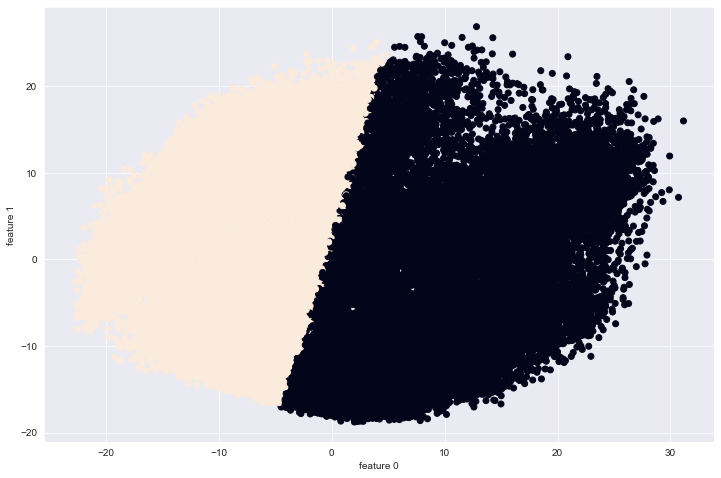

Clustering Accuracy PCA - Flatten Image (Train): 0.6583333333333333
Clustering Accuracy PCA - Flatten Image (Test): 0.8169


In [17]:
cae_flat_pca, train_flat_benchmark_pca, test_flat_benchmark_pca = clus.train_cluster(poisoned_trainloader, trainloader, testloader, classes, "flat", "pca", device, FEATURES_PATH, n_components=10)
print(f"Clustering Accuracy PCA - Flatten Image (Train): {train_flat_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Flatten Image (Test): {test_flat_benchmark_pca[1]['clustering_accuracy']}")

##### Clustering with Feature Extraction
Use VGG16 to extract features from images before clustering.

Retrieve testing image features: 100%|██████████| 157/157 [00:05<00:00, 29.62it/s]


Saving feature data to disk...
Clustering the data...
Fashion MNIST - feature pca 10 Components - ACCURACY: 0.5206458333333334


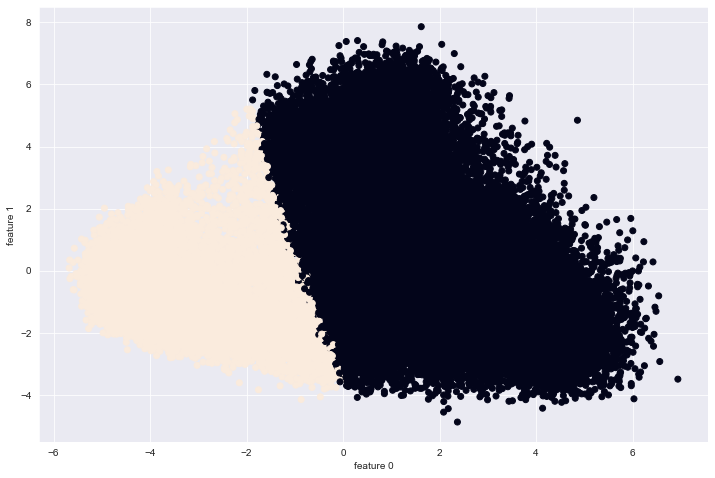

Clustering Accuracy PCA - Feature Image (Train): 0.7106458333333333
Clustering Accuracy PCA - Feature Image (Test): 0.9214


In [18]:
cae_feature_pca, train_feature_benchmark_pca, test_feature_benchmark_pca = clus.train_cluster(poisoned_trainloader, trainloader, testloader, classes, "feature", "pca", device, FEATURES_PATH, n_components=10)
print(f"Clustering Accuracy PCA - Feature Image (Train): {train_feature_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Feature Image (Test): {test_feature_benchmark_pca[1]['clustering_accuracy']}")

### Ensemble

In [19]:
from ensemble_models import train_split_models

In [20]:
avg_train_loss, avg_valid_loss, avg_valid_acc, models_class_acc = train_split_models(poisoned_dataset, testloader, classes, device, epochs=10, n_splits=6, class_labels=classes)

Training model...


100%|██████████| 125/125 [00:02<00:00, 58.87it/s]


Epoch: 1/10  Training loss: 0.5826  Validation loss: 0.5772  Validation accuracy: 0.7500


100%|██████████| 125/125 [00:02<00:00, 58.37it/s]


Epoch: 2/10  Training loss: 0.5718  Validation loss: 0.5686  Validation accuracy: 0.7495


100%|██████████| 125/125 [00:02<00:00, 54.82it/s]


Epoch: 3/10  Training loss: 0.5680  Validation loss: 0.5744  Validation accuracy: 0.7425


100%|██████████| 125/125 [00:02<00:00, 51.98it/s]


Epoch: 4/10  Training loss: 0.5628  Validation loss: 0.5700  Validation accuracy: 0.7500


100%|██████████| 125/125 [00:02<00:00, 58.11it/s]


Epoch: 5/10  Training loss: 0.5615  Validation loss: 0.5699  Validation accuracy: 0.7440


100%|██████████| 125/125 [00:02<00:00, 46.68it/s]


Epoch: 6/10  Training loss: 0.5624  Validation loss: 0.5695  Validation accuracy: 0.7470


100%|██████████| 125/125 [00:02<00:00, 47.64it/s]


Epoch: 7/10  Training loss: 0.5629  Validation loss: 0.5639  Validation accuracy: 0.7505


100%|██████████| 125/125 [00:02<00:00, 42.39it/s]


Epoch: 8/10  Training loss: 0.5591  Validation loss: 0.5749  Validation accuracy: 0.7460


100%|██████████| 125/125 [00:02<00:00, 48.68it/s]


Epoch: 9/10  Training loss: 0.5603  Validation loss: 0.5702  Validation accuracy: 0.7410


100%|██████████| 125/125 [00:02<00:00, 49.25it/s]


Epoch: 10/10  Training loss: 0.5592  Validation loss: 0.5881  Validation accuracy: 0.7420
Accuracy of Apparel: 99.55%
Accuracy of Accessories: 94.55%
Training model...


100%|██████████| 125/125 [00:02<00:00, 48.37it/s]


Epoch: 1/10  Training loss: 0.5886  Validation loss: 0.5813  Validation accuracy: 0.7465


100%|██████████| 125/125 [00:02<00:00, 50.27it/s]


Epoch: 2/10  Training loss: 0.5698  Validation loss: 0.5670  Validation accuracy: 0.7505


100%|██████████| 125/125 [00:02<00:00, 54.46it/s]


Epoch: 3/10  Training loss: 0.5719  Validation loss: 0.5807  Validation accuracy: 0.7495


100%|██████████| 125/125 [00:02<00:00, 54.03it/s]


Epoch: 4/10  Training loss: 0.5671  Validation loss: 0.5790  Validation accuracy: 0.7460


100%|██████████| 125/125 [00:02<00:00, 53.43it/s]


Epoch: 5/10  Training loss: 0.5672  Validation loss: 0.5644  Validation accuracy: 0.7485


100%|██████████| 125/125 [00:02<00:00, 53.95it/s]


Epoch: 6/10  Training loss: 0.5630  Validation loss: 0.5830  Validation accuracy: 0.7475


100%|██████████| 125/125 [00:02<00:00, 53.80it/s]


Epoch: 7/10  Training loss: 0.5644  Validation loss: 0.5644  Validation accuracy: 0.7470


100%|██████████| 125/125 [00:02<00:00, 53.89it/s]


Epoch: 8/10  Training loss: 0.5614  Validation loss: 0.5670  Validation accuracy: 0.7480


100%|██████████| 125/125 [00:02<00:00, 54.61it/s]


Epoch: 9/10  Training loss: 0.5598  Validation loss: 0.5758  Validation accuracy: 0.7465


100%|██████████| 125/125 [00:02<00:00, 52.48it/s]


Epoch: 10/10  Training loss: 0.5592  Validation loss: 0.5623  Validation accuracy: 0.7455
Accuracy of Apparel: 98.08%
Accuracy of Accessories: 99.10%
Training model...


100%|██████████| 125/125 [00:02<00:00, 52.77it/s]


Epoch: 1/10  Training loss: 0.5926  Validation loss: 0.5889  Validation accuracy: 0.7450


100%|██████████| 125/125 [00:02<00:00, 53.76it/s]


Epoch: 2/10  Training loss: 0.5676  Validation loss: 0.5735  Validation accuracy: 0.7465


100%|██████████| 125/125 [00:02<00:00, 52.92it/s]


Epoch: 3/10  Training loss: 0.5664  Validation loss: 0.5648  Validation accuracy: 0.7465


100%|██████████| 125/125 [00:02<00:00, 53.61it/s]


Epoch: 4/10  Training loss: 0.5641  Validation loss: 0.5622  Validation accuracy: 0.7465


100%|██████████| 125/125 [00:02<00:00, 54.20it/s]


Epoch: 5/10  Training loss: 0.5653  Validation loss: 0.5690  Validation accuracy: 0.7470


100%|██████████| 125/125 [00:02<00:00, 53.62it/s]


Epoch: 6/10  Training loss: 0.5658  Validation loss: 0.5703  Validation accuracy: 0.7480


100%|██████████| 125/125 [00:02<00:00, 53.03it/s]


Epoch: 7/10  Training loss: 0.5635  Validation loss: 0.5688  Validation accuracy: 0.7460


100%|██████████| 125/125 [00:02<00:00, 54.21it/s]


Epoch: 8/10  Training loss: 0.5636  Validation loss: 0.5676  Validation accuracy: 0.7455


100%|██████████| 125/125 [00:02<00:00, 55.41it/s]


Epoch: 9/10  Training loss: 0.5596  Validation loss: 0.5722  Validation accuracy: 0.7460


100%|██████████| 125/125 [00:02<00:00, 54.11it/s]


Epoch: 10/10  Training loss: 0.5609  Validation loss: 0.5723  Validation accuracy: 0.7370
Accuracy of Apparel: 99.43%
Accuracy of Accessories: 90.88%
Training model...


100%|██████████| 125/125 [00:02<00:00, 55.35it/s]


Epoch: 1/10  Training loss: 0.5829  Validation loss: 0.5685  Validation accuracy: 0.7450


100%|██████████| 125/125 [00:02<00:00, 54.32it/s]


Epoch: 2/10  Training loss: 0.5704  Validation loss: 0.5641  Validation accuracy: 0.7445


100%|██████████| 125/125 [00:02<00:00, 54.22it/s]


Epoch: 3/10  Training loss: 0.5681  Validation loss: 0.5762  Validation accuracy: 0.7460


100%|██████████| 125/125 [00:02<00:00, 53.98it/s]


Epoch: 4/10  Training loss: 0.5660  Validation loss: 0.5641  Validation accuracy: 0.7480


100%|██████████| 125/125 [00:02<00:00, 55.38it/s]


Epoch: 5/10  Training loss: 0.5657  Validation loss: 0.5717  Validation accuracy: 0.7480


100%|██████████| 125/125 [00:02<00:00, 54.02it/s]


Epoch: 6/10  Training loss: 0.5615  Validation loss: 0.5667  Validation accuracy: 0.7470


100%|██████████| 125/125 [00:02<00:00, 56.14it/s]


Epoch: 7/10  Training loss: 0.5605  Validation loss: 0.5701  Validation accuracy: 0.7425


100%|██████████| 125/125 [00:02<00:00, 53.85it/s]


Epoch: 8/10  Training loss: 0.5570  Validation loss: 0.5615  Validation accuracy: 0.7455


100%|██████████| 125/125 [00:02<00:00, 54.81it/s]


Epoch: 9/10  Training loss: 0.5586  Validation loss: 0.5636  Validation accuracy: 0.7440


100%|██████████| 125/125 [00:02<00:00, 49.52it/s]


Epoch: 10/10  Training loss: 0.5571  Validation loss: 0.5735  Validation accuracy: 0.7400
Accuracy of Apparel: 97.03%
Accuracy of Accessories: 97.40%
Training model...


100%|██████████| 125/125 [00:02<00:00, 47.41it/s]


Epoch: 1/10  Training loss: 0.5871  Validation loss: 0.5845  Validation accuracy: 0.7445


100%|██████████| 125/125 [00:02<00:00, 51.96it/s]


Epoch: 2/10  Training loss: 0.5681  Validation loss: 0.5774  Validation accuracy: 0.7435


100%|██████████| 125/125 [00:02<00:00, 52.33it/s]


Epoch: 3/10  Training loss: 0.5665  Validation loss: 0.5781  Validation accuracy: 0.7455


100%|██████████| 125/125 [00:02<00:00, 56.13it/s]


Epoch: 4/10  Training loss: 0.5638  Validation loss: 0.5698  Validation accuracy: 0.7475


100%|██████████| 125/125 [00:02<00:00, 46.43it/s]


Epoch: 5/10  Training loss: 0.5629  Validation loss: 0.5735  Validation accuracy: 0.7450


100%|██████████| 125/125 [00:02<00:00, 51.71it/s]


Epoch: 6/10  Training loss: 0.5621  Validation loss: 0.5741  Validation accuracy: 0.7460


100%|██████████| 125/125 [00:02<00:00, 59.49it/s]


Epoch: 7/10  Training loss: 0.5591  Validation loss: 0.5686  Validation accuracy: 0.7440


100%|██████████| 125/125 [00:02<00:00, 60.71it/s]


Epoch: 8/10  Training loss: 0.5578  Validation loss: 0.5796  Validation accuracy: 0.7475


100%|██████████| 125/125 [00:02<00:00, 60.51it/s]


Epoch: 9/10  Training loss: 0.5563  Validation loss: 0.5813  Validation accuracy: 0.7450


100%|██████████| 125/125 [00:02<00:00, 56.15it/s]


Epoch: 10/10  Training loss: 0.5567  Validation loss: 0.5773  Validation accuracy: 0.7430
Accuracy of Apparel: 99.02%
Accuracy of Accessories: 97.00%
Training model...


100%|██████████| 125/125 [00:02<00:00, 49.39it/s]


Epoch: 1/10  Training loss: 0.5809  Validation loss: 0.5942  Validation accuracy: 0.7485


100%|██████████| 125/125 [00:02<00:00, 52.17it/s]


Epoch: 2/10  Training loss: 0.5746  Validation loss: 0.5755  Validation accuracy: 0.7445


100%|██████████| 125/125 [00:02<00:00, 52.04it/s]


Epoch: 3/10  Training loss: 0.5705  Validation loss: 0.5665  Validation accuracy: 0.7490


100%|██████████| 125/125 [00:02<00:00, 56.72it/s]


Epoch: 4/10  Training loss: 0.5647  Validation loss: 0.5685  Validation accuracy: 0.7480


100%|██████████| 125/125 [00:02<00:00, 56.03it/s]


Epoch: 5/10  Training loss: 0.5618  Validation loss: 0.5703  Validation accuracy: 0.7435


100%|██████████| 125/125 [00:02<00:00, 56.66it/s]


Epoch: 6/10  Training loss: 0.5610  Validation loss: 0.5737  Validation accuracy: 0.7390


100%|██████████| 125/125 [00:02<00:00, 55.37it/s]


Epoch: 7/10  Training loss: 0.5639  Validation loss: 0.5735  Validation accuracy: 0.7425


100%|██████████| 125/125 [00:02<00:00, 56.40it/s]


Epoch: 8/10  Training loss: 0.5604  Validation loss: 0.5742  Validation accuracy: 0.7440


100%|██████████| 125/125 [00:02<00:00, 56.06it/s]


Epoch: 9/10  Training loss: 0.5593  Validation loss: 0.5698  Validation accuracy: 0.7415


100%|██████████| 125/125 [00:02<00:00, 56.26it/s]


Epoch: 10/10  Training loss: 0.5566  Validation loss: 0.5696  Validation accuracy: 0.7390
Accuracy of Apparel: 97.75%
Accuracy of Accessories: 97.95%


In [21]:
print(f'Train loss: {avg_train_loss:.6f}, Validation loss: {avg_valid_loss:.6f}, Validation acc: {avg_valid_acc:.2f}')

Train loss: 0.558297, Validation loss: 0.573840, Validation acc: 0.74


In [22]:
models_class_acc

{0: ['Accuracy of Apparel: 99.55%', 'Accuracy of Accessories: 94.55%'],
 1: ['Accuracy of Apparel: 98.08%', 'Accuracy of Accessories: 99.10%'],
 2: ['Accuracy of Apparel: 99.43%', 'Accuracy of Accessories: 90.88%'],
 3: ['Accuracy of Apparel: 97.03%', 'Accuracy of Accessories: 97.40%'],
 4: ['Accuracy of Apparel: 99.02%', 'Accuracy of Accessories: 97.00%'],
 5: ['Accuracy of Apparel: 97.75%', 'Accuracy of Accessories: 97.95%']}

In [27]:
avg_acc_classes = {k:0 for k in classes.keys()}
avg_acc = 0
for key, value in models_class_acc.items():
	for k, v in avg_acc_classes.items():
		avg_acc_classes[k] += float(value[k].split(' ')[-1][:-1])

avg_acc_classes = {k:v/len(models_class_acc) for k, v in avg_acc_classes.items()}
avg_acc = sum(avg_acc_classes.values())/len(avg_acc_classes)

for k,v in avg_acc_classes.items():
	print(f'Avg {classes[k]}: {v:.2f}')
print(f'Avg: {avg_acc:.2f}')


Avg Apparel: 98.48
Avg Accessories: 96.15
Avg: 97.31
